# <span style="color:cornflowerblue"><center>Predicción del consumo mensual de agua potable en una red de distribución urbana usando una red neuronal LSTM</center></span>
## <span style="color:cornflowerblue"><center>Diplomado en Ciencia de Datos</center></span>
### <span style="color:cornflowerblue"><center>Universidad Nacional de Colombia Sede Bogotá</center></span>
<span style="color:cornflowerblue">**Estudiante**: L. Felipe Castañeda G.</span>

<span style="color:cornflowerblue">**Asesor**: Álvaro Mauricio Montenegro Díaz.</span>

## Contenidos:
* [Objetivos](#Objetivos)
* [Importar las librerías](#Importar-las-librerías)
* [Lectura de los datos](#Lectura-de-los-datos)
* [Limpieza y organización de los datos](#Limpieza-y-organización-de-los-datos)
* [Análisis exploratorio inicial](#Análisis-exploratorio-inicial)
* [Predicción mensual del consumo de agua potable usando una red neuronal LSTM](#Predicción-mensual-del-consumo-de-agua-potable-usando-una-red-neuronal-LSTM)

## <span style="color:cornflowerblue">Objetivos</span>
- Crear un modelo de red neuronal LSTM para la predicción mensual del consumo de agua potable que use como datos de entrada una serie temporal.
- Crear un modelo de red neuronal LSTM para la predicción mensual del consumo de agua potable que use como datos de entrada varias series temporales.

## <span style="color:cornflowerblue">1. Importar las librerías</span>

In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# from __future__ import absolute_import, division, print_function, unicode_literals

Versión de Tensorflow:  2.9.1


## <span style="color:cornflowerblue">2. Lectura de los datos</span>

Los datos de consumo son los de una red de distribución de agua potable urbana de un municipio del departamento de Caldas. Son 783.000 observaciones del consumo mensual en metros cúbicos de los usuarios residenciales y no residenciales que van desde julio de 2017 hasta diciembre de 2021.

Los datos de consumo presenan las siguientes características:
- Número de la matrícula.
- Nombre del suscriptor.
- Dirección.
- Servicio: Residencial, comercial, industrial y oficial.
- Estrato: 1, 2, 3 y 4.
- Número del contador.
- Lectura actual.
- Lectura anterior.
- Metros consumidos.
- Mes.
- Año.

Los datos climatológicos corresponden a las siguientes características:
- Año.
- Mes.
- Precipitaciones: Ppt (mm).
- Días soleados: DSL (#).
- Temperaturas máxima, mínima y promedio: TMáx (ºC), TMín (ºC) y TPro (ºC).
- Presiones barométricas máxima, mínima y media: Máx PB (hPa), Mín PB (hPa) y Med PB (hPa).
- Velocidad del viento promedio: VVPro (m/s).
- Humedad relativa máxima, mínima y media: HR Máx (%), HR Mín (%) y HR Med (%).
- Radiación solar máxima y media: RS Máx (W/m2) y RS Med (W/m2).
- Índice de aridez mensual: IAM.

Los datos climatológicos pueden ser descargados en [CEDIAC](https://cdiac.manizales.unal.edu.co/indicadores/public/index).

### <span style="color:cornflowerblue">2.1 Lectura de los datos del consumo de agua potable</span>

In [2]:
raw_consumo = pd.read_excel("..\Data\Consumo\Consumo_2017_2021.xlsx")

### <span style="color:cornflowerblue">2.2 Lectura de los datos climatológicos</span>

In [3]:
# Read clima excel file.
raw_clima = pd.read_excel("..\Data\Climatologicos_Mensual\Climatologicos_Mensual_2017_2022.xlsx")

### Realizar copias de los datos leídos.

In [4]:
# Make a copy
consumo = raw_consumo.copy()

In [5]:
# Make a copy
clima = raw_clima.copy()

## <span style="color:cornflowerblue">3. Limpieza y organización de los datos</span>

### <span style="color:cornflowerblue">3.1 Limpieza y organización de los datos para el consumo de agua potable</span>

In [6]:
consumo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783000 entries, 0 to 782999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Matricula         783000 non-null  int64 
 1   NombreSuscriptor  783000 non-null  object
 2   Direccion         783000 non-null  object
 3   Servicio          783000 non-null  object
 4   Estrato           783000 non-null  int64 
 5   NumeroContador    782958 non-null  object
 6   LecturaActual     783000 non-null  int64 
 7   LecturaAnterior   783000 non-null  int64 
 8   MetrosConsumidos  783000 non-null  int64 
 9   Mes               783000 non-null  object
 10  Ano               783000 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 65.7+ MB


Revisar si las caractarísticas útiles en el análisis presentan filas sin datos.

In [7]:
consumo.isna().sum()

Matricula            0
NombreSuscriptor     0
Direccion            0
Servicio             0
Estrato              0
NumeroContador      42
LecturaActual        0
LecturaAnterior      0
MetrosConsumidos     0
Mes                  0
Ano                  0
dtype: int64

La columna 'NumeroContador'presenta 42 filas sin datos. En este caso, como se analizará el consumo, no se borran esas 42 filas.

Remover aquellas filas en las que el consumo sea menor que cero.

In [8]:
consumo = consumo.drop(consumo.index[consumo['MetrosConsumidos'] < 0])
consumo.shape

(782993, 11)

Remover las columnas que no se utilizarán en el análisis.

In [9]:
consumo.drop(['Matricula',"NombreSuscriptor","Direccion","NumeroContador",'Servicio','Estrato'],
             axis=1, inplace=True)
consumo.columns

Index(['LecturaActual', 'LecturaAnterior', 'MetrosConsumidos', 'Mes', 'Ano'], dtype='object')

Realizar una limpieza en la columna 'Mes'.

In [10]:
consumo["Mes"] = (consumo["Mes"]
                          # .str.lower()
                          #.str.replace("[^a-záéíóúüñ ]","")
                          # .str.replace(" +"," ")
                          .str.replace('[^\w+]|\d+|\s+|_',' ', regex=True)
                          .str.strip()
                          # .str.title()
                          )
consumo["Mes"].astype("str")
consumo["Mes"].head(12)

0          JULIO
1         AGOSTO
2     SEPTIEMBRE
3        OCTUBRE
4      NOVIEMBRE
5      DICIEMBRE
6          ENERO
7        FEBRERO
8          MARZO
9          ABRIL
10          MAYO
11         JUNIO
Name: Mes, dtype: object

Cambiar el nombre del mes por su número correspondiente en la columna 'Mes'.

In [11]:
cm_dict = {'ENERO':1,'FEBRERO':2,'MARZO':3,'ABRIL':4,'MAYO':5,'JUNIO':6,
          'JULIO':7,'AGOSTO':8,'SEPTIEMBRE':9,'OCTUBRE':10,'NOVIEMBRE':11,'DICIEMBRE':12}
consumo = consumo.replace({'Mes':cm_dict})
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,Mes,Ano
0,6028,6018,10,7,2017
1,6051,6028,23,8,2017
2,6068,6051,17,9,2017
3,6085,6068,17,10,2017
4,6103,6085,18,11,2017


Crear una columna 'day' con valores iguales a '1'.

In [12]:
consumo["day"] = 1
day_consumo = consumo["day"]
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,Mes,Ano,day
0,6028,6018,10,7,2017,1
1,6051,6028,23,8,2017,1
2,6068,6051,17,9,2017,1
3,6085,6068,17,10,2017,1
4,6103,6085,18,11,2017,1


Cambiar el nombre de las columnas 'Ano' y 'Mes', para crear una columna 'Date' con características de fecha en el formato 'AAAA-MM-DD'.

In [13]:
consumo.rename(columns = {'Ano':'year','Mes':'month'}, inplace=True)
consumo['Date'] = pd.to_datetime(consumo[["year","month","day"]])
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,month,year,day,Date
0,6028,6018,10,7,2017,1,2017-07-01
1,6051,6028,23,8,2017,1,2017-08-01
2,6068,6051,17,9,2017,1,2017-09-01
3,6085,6068,17,10,2017,1,2017-10-01
4,6103,6085,18,11,2017,1,2017-11-01


Borrar las columnas 'year', 'month' y 'day'.

In [14]:
consumo.drop(["year","month","day"], axis=1,inplace=True) #inplace=True, para que me modifique la BD
consumo.head()

,LecturaActual,LecturaAnterior,MetrosConsumidos,Date
0,6028,6018,10,2017-07-01
1,6051,6028,23,2017-08-01
2,6068,6051,17,2017-09-01
3,6085,6068,17,2017-10-01
4,6103,6085,18,2017-11-01


Crear un dataframe llamado 'consumo' con las columnas 'Date', 'MetrosConsumidos', 'LecturaActual' y 'LecturaAnterior'.

In [15]:
consumo['Date'] = pd.to_datetime(consumo.Date,format='%Y-%m-%d')
consumo = pd.DataFrame(consumo[['Date','MetrosConsumidos','LecturaActual','LecturaAnterior']])
consumo.head()

,Date,MetrosConsumidos,LecturaActual,LecturaAnterior
0,2017-07-01,10,6028,6018
1,2017-08-01,23,6051,6028
2,2017-09-01,17,6068,6051
3,2017-10-01,17,6085,6068
4,2017-11-01,18,6103,6085


In [16]:
consumo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782993 entries, 0 to 782999
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              782993 non-null  datetime64[ns]
 1   MetrosConsumidos  782993 non-null  int64         
 2   LecturaActual     782993 non-null  int64         
 3   LecturaAnterior   782993 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 29.9 MB


Creación del dataframe 'consumo_mensual', agrupando el dataframe 'consumo' por fecha 'Date'

In [17]:
consumo_mensual = consumo.groupby('Date',as_index=False).sum()
consumo_mensual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              54 non-null     datetime64[ns]
 1   MetrosConsumidos  54 non-null     int64         
 2   LecturaActual     54 non-null     int64         
 3   LecturaAnterior   54 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.8 KB


In [18]:
consumo_mensual.shape

(54, 4)

In [19]:
consumo_mensual.head()

,Date,MetrosConsumidos,LecturaActual,LecturaAnterior
0,2017-07-01,139987,17692115,17552128
1,2017-08-01,222055,17824508,17602453
2,2017-09-01,149277,17816058,17666781
3,2017-10-01,175709,17898418,17722709
4,2017-11-01,175364,18924638,18749274


### <span style="color:cornflowerblue">3.2 Limpieza y organización de datos climatológicos</span>

In [20]:
print('Shape of the clima:')
print(clima.shape)

Shape of the clima:
(61, 24)


In [21]:
clima.head()

,Año,Mes,Ppt (mm),DSL (#),TMáx (ºC),TMín (ºC),TPro (ºC),Máx PB (hPa),Mín PB (hPa),Med PB (hPa),...,DB.1,HR Máx (%),HR Mín (%),HR Med (%),CI,SE,RS Máx (W/m2),RS Med (W/m2),IAM,ZAM
0,2017,1,233.2,17,26.7,12.8,19.3,823.0,809.3,816.8,...,Aire ligero,97.0,36.0,83.7,8.9,Agradable,1273,348.0,95.5,Perhúmedas
1,2017,2,107.8,17,27.8,13.2,20.4,822.7,808.3,816.3,...,Aire ligero,98.0,41.0,77.7,7.8,Agradable,1190,399.4,42.6,Húmeda
2,2017,3,293.6,7,26.4,15.2,19.0,822.5,811.2,817.7,...,Aire ligero,98.0,53.0,87.9,9.3,Agradable,1213,278.4,121.5,Perhúmedas
3,2017,4,357.4,14,28.2,14.8,20.1,821.4,809.0,816.1,...,Aire ligero,98.0,43.0,83.6,8.4,Agradable,1311,343.6,142.5,Perhúmedas
4,2017,5,459.6,9,27.3,15.7,19.7,821.8,807.7,817.5,...,Aire ligero,98.0,56.0,87.2,8.9,Agradable,1264,298.3,185.7,Perhúmedas


In [22]:
clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Año            61 non-null     int64  
 1   Mes            61 non-null     int64  
 2   Ppt (mm)       53 non-null     float64
 3   DSL (#)        61 non-null     int64  
 4   TMáx (ºC)      61 non-null     float64
 5   TMín (ºC)      61 non-null     float64
 6   TPro (ºC)      61 non-null     float64
 7   Máx PB (hPa)   61 non-null     float64
 8   Mín PB (hPa)   61 non-null     float64
 9   Med PB (hPa)   61 non-null     float64
 10  EB             61 non-null     int64  
 11  DB             61 non-null     object 
 12  VVPro          61 non-null     float64
 13  EB.1           61 non-null     int64  
 14  DB.1           61 non-null     object 
 15  HR Máx (%)     49 non-null     float64
 16  HR Mín (%)     49 non-null     float64
 17  HR Med (%)     49 non-null     float64
 18  CI          

Remover aquellas filas cuyas entradas no contengan datos.

In [23]:
clima.isna().sum()

Año               0
Mes               0
Ppt (mm)          8
DSL (#)           0
TMáx (ºC)         0
TMín (ºC)         0
TPro (ºC)         0
Máx PB (hPa)      0
Mín PB (hPa)      0
Med PB (hPa)      0
EB                0
DB                0
VVPro             0
EB.1              0
DB.1              0
HR Máx (%)       12
HR Mín (%)       12
HR Med (%)       12
CI                0
SE                0
RS Máx (W/m2)     0
RS Med (W/m2)     0
IAM               0
ZAM               0
dtype: int64

In [24]:
clima = clima.dropna()
clima.shape

(49, 24)

Remover las columnas que no se utilizarán en el análisis.

In [25]:
clima.drop(['EB', 'DB', 'EB.1', 'DB.1', 'CI', 'SE', 'ZAM'], axis=1, inplace=True)
clima.columns

Index(['Año', 'Mes', 'Ppt (mm)', 'DSL (#)', 'TMáx (ºC)', 'TMín (ºC)',
       'TPro (ºC)', 'Máx PB (hPa)', 'Mín PB (hPa)', 'Med PB (hPa)', 'VVPro',
       'HR Máx (%)', 'HR Mín (%)', 'HR Med (%)', 'RS Máx (W/m2)',
       'RS Med (W/m2)', 'IAM'],
      dtype='object')

In [26]:
clima.head()

,Año,Mes,Ppt (mm),DSL (#),TMáx (ºC),TMín (ºC),TPro (ºC),Máx PB (hPa),Mín PB (hPa),Med PB (hPa),VVPro,HR Máx (%),HR Mín (%),HR Med (%),RS Máx (W/m2),RS Med (W/m2),IAM
0,2017,1,233.2,17,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5
1,2017,2,107.8,17,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6
2,2017,3,293.6,7,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5
3,2017,4,357.4,14,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5
4,2017,5,459.6,9,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7


Crear una columna 'day' con valores iguales a '1'.

In [27]:
clima["day"] = 1
day_clima = clima["day"]
clima.head()

,Año,Mes,Ppt (mm),DSL (#),TMáx (ºC),TMín (ºC),TPro (ºC),Máx PB (hPa),Mín PB (hPa),Med PB (hPa),VVPro,HR Máx (%),HR Mín (%),HR Med (%),RS Máx (W/m2),RS Med (W/m2),IAM,day
0,2017,1,233.2,17,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5,1
1,2017,2,107.8,17,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6,1
2,2017,3,293.6,7,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5,1
3,2017,4,357.4,14,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5,1
4,2017,5,459.6,9,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7,1


Cambiar el nombre de algunas columnas.

In [28]:
# Rename some columns from 'clima'
clima.rename(columns={"Año":"year", "Mes": "month", "Ppt (mm)":"Ppt", "DSL (#)": "DSL", 'TMáx (ºC)':'TMax','TMín (ºC)':'TMin','TPro (ºC)':'TPro',
                      'Máx PB (hPa)':'PBMax','Mín PB (hPa)':'PBMin','Med PB (hPa)':'PBMed',
                      'HR Máx (%)':'HRMax','HR Mín (%)':'HRMin',"HR Med (%)":"HRMed",
                      'RS Máx (W/m2)':'RSMax',"RS Med (W/m2)":"RSMed"},inplace=True)
clima.columns

Index(['year', 'month', 'Ppt', 'DSL', 'TMax', 'TMin', 'TPro', 'PBMax', 'PBMin',
       'PBMed', 'VVPro', 'HRMax', 'HRMin', 'HRMed', 'RSMax', 'RSMed', 'IAM',
       'day'],
      dtype='object')

Crear una columna 'Date' con características de fecha en el formato 'AAAA-MM-DD'.

In [29]:
clima['Date'] = pd.to_datetime(clima[["year","month","day"]])
clima.head()

,year,month,Ppt,DSL,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM,day,Date
0,2017,1,233.2,17,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5,1,2017-01-01
1,2017,2,107.8,17,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6,1,2017-02-01
2,2017,3,293.6,7,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5,1,2017-03-01
3,2017,4,357.4,14,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5,1,2017-04-01
4,2017,5,459.6,9,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7,1,2017-05-01


Crear el dataframe 'clima_mensual' con las columnas de interés.

In [30]:
clima['Date'] = pd.to_datetime(clima.Date,format='%Y-%m-%d')
clima_mensual = pd.DataFrame(clima[['Date','Ppt', 'DSL', 'TMax', 'TMin', 'TPro', 'PBMax', 'PBMin', 'PBMed',
       'VVPro', 'HRMax', 'HRMin', 'HRMed', 'RSMax', 'RSMed', 'IAM']])
clima_mensual.head()

,Date,Ppt,DSL,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
0,2017-01-01,233.2,17,26.7,12.8,19.3,823.0,809.3,816.8,1.3,97.0,36.0,83.7,1273,348.0,95.5
1,2017-02-01,107.8,17,27.8,13.2,20.4,822.7,808.3,816.3,1.4,98.0,41.0,77.7,1190,399.4,42.6
2,2017-03-01,293.6,7,26.4,15.2,19.0,822.5,811.2,817.7,1.1,98.0,53.0,87.9,1213,278.4,121.5
3,2017-04-01,357.4,14,28.2,14.8,20.1,821.4,809.0,816.1,1.2,98.0,43.0,83.6,1311,343.6,142.5
4,2017-05-01,459.6,9,27.3,15.7,19.7,821.8,807.7,817.5,1.2,98.0,56.0,87.2,1264,298.3,185.7


In [31]:
clima_mensual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 56
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    49 non-null     datetime64[ns]
 1   Ppt     49 non-null     float64       
 2   DSL     49 non-null     int64         
 3   TMax    49 non-null     float64       
 4   TMin    49 non-null     float64       
 5   TPro    49 non-null     float64       
 6   PBMax   49 non-null     float64       
 7   PBMin   49 non-null     float64       
 8   PBMed   49 non-null     float64       
 9   VVPro   49 non-null     float64       
 10  HRMax   49 non-null     float64       
 11  HRMin   49 non-null     float64       
 12  HRMed   49 non-null     float64       
 13  RSMax   49 non-null     int64         
 14  RSMed   49 non-null     float64       
 15  IAM     49 non-null     float64       
dtypes: datetime64[ns](1), float64(13), int64(2)
memory usage: 6.5 KB


### <span style="color:cornflowerblue">3.3 Concatenación de los dataframe 'Consumo' y 'Clima' y creación de 'dataframe'</span>

In [32]:
dataframe = pd.concat([consumo_mensual.set_index('Date'),clima_mensual.set_index('Date')], axis=1, join='inner').reset_index()
dataframe.head()

,Date,MetrosConsumidos,LecturaActual,LecturaAnterior,Ppt,DSL,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
0,2017-07-01,139987,17692115,17552128,43.4,15,26.6,15.4,20.2,821.1,811.6,816.9,1.3,97.0,53.0,82.1,1248,319.3,17.2
1,2017-08-01,222055,17824508,17602453,112.0,16,27.4,15.3,20.2,821.9,810.2,816.7,1.2,97.0,49.0,82.3,1280,362.0,44.5
2,2017-09-01,149277,17816058,17666781,144.2,12,27.9,14.7,19.8,821.8,809.9,816.9,1.3,98.0,43.0,83.3,1311,343.5,58.1
3,2017-10-01,175709,17898418,17722709,206.4,11,28.3,13.9,19.5,823.2,809.1,816.5,1.2,98.0,52.0,85.9,1308,322.5,84.0
4,2017-11-01,175364,18924638,18749274,283.2,14,26.5,14.7,19.4,822.1,809.2,816.4,1.2,98.0,59.0,87.8,1383,356.9,115.6


In [33]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              43 non-null     datetime64[ns]
 1   MetrosConsumidos  43 non-null     int64         
 2   LecturaActual     43 non-null     int64         
 3   LecturaAnterior   43 non-null     int64         
 4   Ppt               43 non-null     float64       
 5   DSL               43 non-null     int64         
 6   TMax              43 non-null     float64       
 7   TMin              43 non-null     float64       
 8   TPro              43 non-null     float64       
 9   PBMax             43 non-null     float64       
 10  PBMin             43 non-null     float64       
 11  PBMed             43 non-null     float64       
 12  VVPro             43 non-null     float64       
 13  HRMax             43 non-null     float64       
 14  HRMin             43 non-nul

Indexar 'dataframe' usando la columna 'Date'.

In [34]:
# Index 'dataframe' by 'Date'
dataframe = dataframe.set_index('Date')
dataframe.head()

,MetrosConsumidos,LecturaActual,LecturaAnterior,Ppt,DSL,TMax,TMin,TPro,PBMax,PBMin,PBMed,VVPro,HRMax,HRMin,HRMed,RSMax,RSMed,IAM
Date,,,,,,,,,,,,,,,,,,
2017-07-01,139987,17692115,17552128,43.4,15,26.6,15.4,20.2,821.1,811.6,816.9,1.3,97.0,53.0,82.1,1248,319.3,17.2
2017-08-01,222055,17824508,17602453,112.0,16,27.4,15.3,20.2,821.9,810.2,816.7,1.2,97.0,49.0,82.3,1280,362.0,44.5
2017-09-01,149277,17816058,17666781,144.2,12,27.9,14.7,19.8,821.8,809.9,816.9,1.3,98.0,43.0,83.3,1311,343.5,58.1
2017-10-01,175709,17898418,17722709,206.4,11,28.3,13.9,19.5,823.2,809.1,816.5,1.2,98.0,52.0,85.9,1308,322.5,84.0
2017-11-01,175364,18924638,18749274,283.2,14,26.5,14.7,19.4,822.1,809.2,816.4,1.2,98.0,59.0,87.8,1383,356.9,115.6


In [35]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2017-07-01 to 2021-09-01
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MetrosConsumidos  43 non-null     int64  
 1   LecturaActual     43 non-null     int64  
 2   LecturaAnterior   43 non-null     int64  
 3   Ppt               43 non-null     float64
 4   DSL               43 non-null     int64  
 5   TMax              43 non-null     float64
 6   TMin              43 non-null     float64
 7   TPro              43 non-null     float64
 8   PBMax             43 non-null     float64
 9   PBMin             43 non-null     float64
 10  PBMed             43 non-null     float64
 11  VVPro             43 non-null     float64
 12  HRMax             43 non-null     float64
 13  HRMin             43 non-null     float64
 14  HRMed             43 non-null     float64
 15  RSMax             43 non-null     int64  
 16  RSMed             43 non-n

## <span style="color:cornflowerblue">4. Análisis exploratorio inicial</span>

### <span style="color:cornflowerblue">4.1 Crear una matriz de correlación usando las columnas del dataframe</span>

<AxesSubplot:>

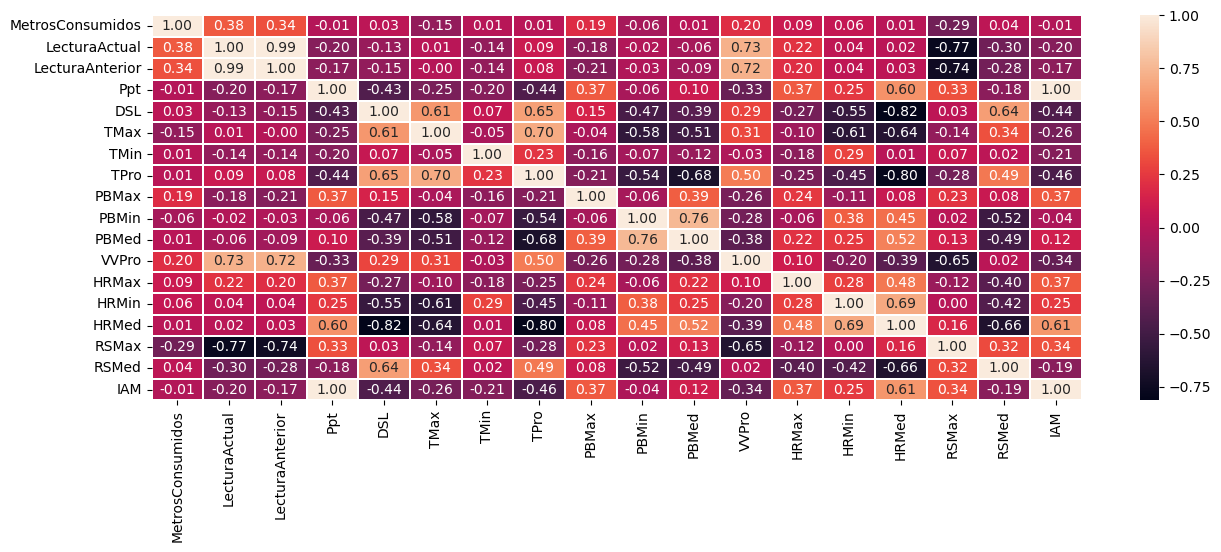

In [36]:
corr_matrix_dataframe = dataframe.corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr_matrix_dataframe, annot=True, linewidths=.25, fmt=".2f")

### <span style="color:cornflowerblue">4.2 Seleccionar las columnas definitivas</span>

Para la predicción de la serie temporal 'Consumo' solo se utilizarán aquellas características que tengan una correlación menor o igual a $-0.15$, o mayor o igual a $0.15$. Dichas características son:
- 'MetrosConsumidos': Consumo.
- 'LecturaActual': Lectura actual.
- 'TMax': Temperatura máxima.
- 'PBMax': Presión barométrica máxima.
- 'VVPro'. Velocidad del viento promedio.
- 'RSMax': Radiación solar máxima.

Se decidió excluir 'LecturaAnterior' pues así como 'LecturaActual', la primera también es un acumulado mensual del consumo de cada usuario.

In [37]:
dataframe = pd.DataFrame(dataframe[['MetrosConsumidos','LecturaActual', 'TMax', 'PBMax', 'VVPro', 'RSMax']])

<AxesSubplot:>

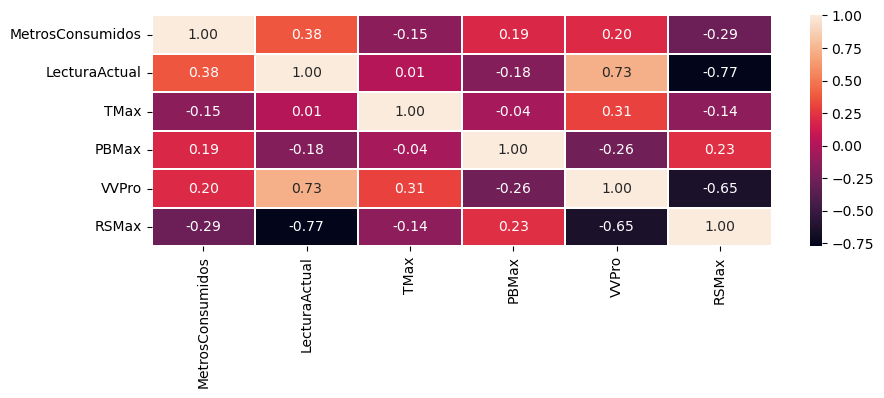

In [38]:
corr_matrix_dataframe = dataframe.corr()
plt.figure(figsize=(10,3))
sns.heatmap(corr_matrix_dataframe, annot=True, linewidths=.25, fmt=".2f")

### <span style="color:cornflowerblue"><span style="color:cornflowerblue">4.3 Estandarización de las columnas<span/>

In [39]:
scaler = StandardScaler()
  
dataframe_standard_scaled = scaler.fit_transform(dataframe)
dataframe_standard_scaled = pd.DataFrame(dataframe_standard_scaled, columns = ['MetrosConsumidos','LecturaActual', 'TMax', 'PBMax',
                                                                              'VVPro', 'RSMax'])

In [40]:
dataframe_standard_scaled.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MetrosConsumidos,43.0,-7.797380e-16,1.011835,-2.809576,-0.463841,-0.077128,0.600204,2.659452
LecturaActual,43.0,4.802360e-16,1.011835,-2.415793,-0.406729,-0.139526,0.840967,1.553209
TMax,43.0,-1.714391e-15,1.011835,-2.002216,-0.625584,-0.141903,0.453397,3.801960
PBMax,43.0,1.627174e-13,1.011835,-2.537577,-0.738327,-0.099883,0.480520,2.453890
VVPro,43.0,1.136042e-16,1.011835,-1.944686,-1.008624,0.551478,0.551478,1.799560
RSMax,43.0,-3.563041e-16,1.011835,-1.225837,-1.080646,0.259073,0.780441,2.007966


### <span style="color:cornflowerblue"><span style="color:cornflowerblue">4.4 Visualización del consumo y las demás series de interés</span>

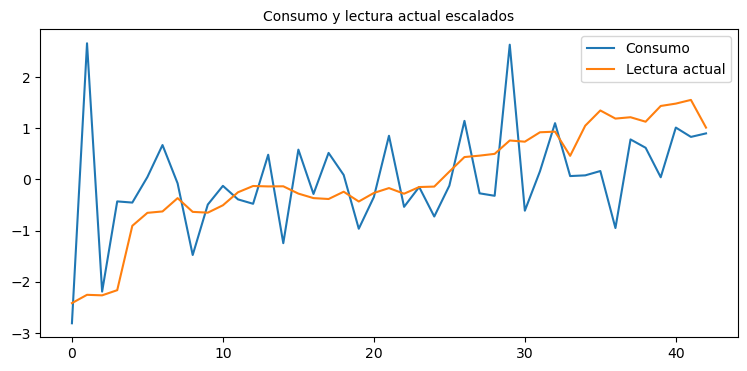

In [41]:
plt.figure(figsize=(9,4))
plt.plot(dataframe_standard_scaled['MetrosConsumidos'], label='Consumo')
plt.plot(dataframe_standard_scaled['LecturaActual'], label='Lectura actual')
plt.title("Consumo y lectura actual escalados", size = 10)
plt.legend()
plt.show()

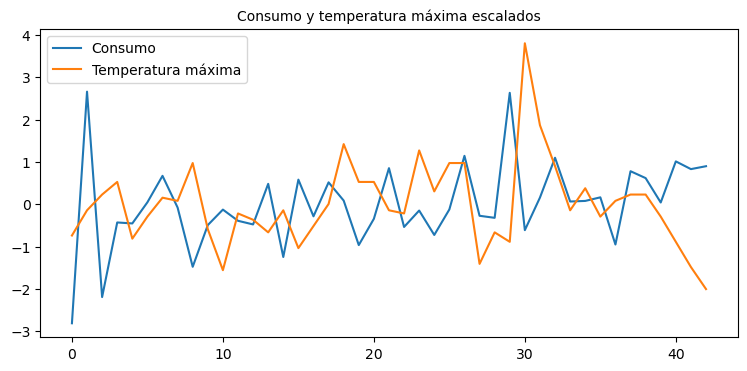

In [42]:
plt.figure(figsize=(9,4))
plt.plot(dataframe_standard_scaled['MetrosConsumidos'], label='Consumo')
plt.plot(dataframe_standard_scaled['TMax'], label='Temperatura máxima')
plt.title("Consumo y temperatura máxima escalados", size = 10)
plt.legend()
plt.show()

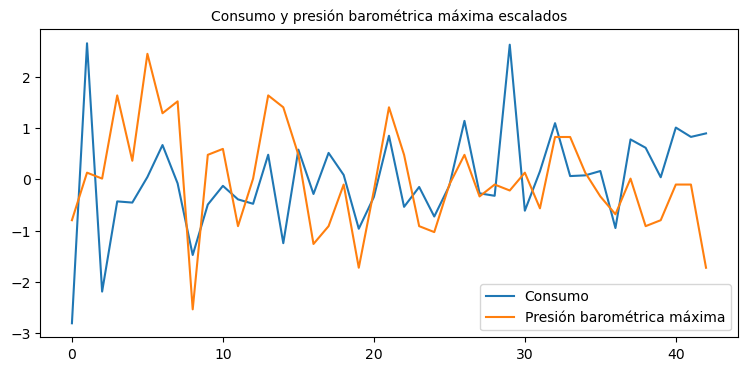

In [43]:
plt.figure(figsize=(9,4))
plt.plot(dataframe_standard_scaled['MetrosConsumidos'], label='Consumo')
plt.plot(dataframe_standard_scaled['PBMax'], label='Presión barométrica máxima')
plt.title("Consumo y presión barométrica máxima escalados", size = 10)
plt.legend()
plt.show()

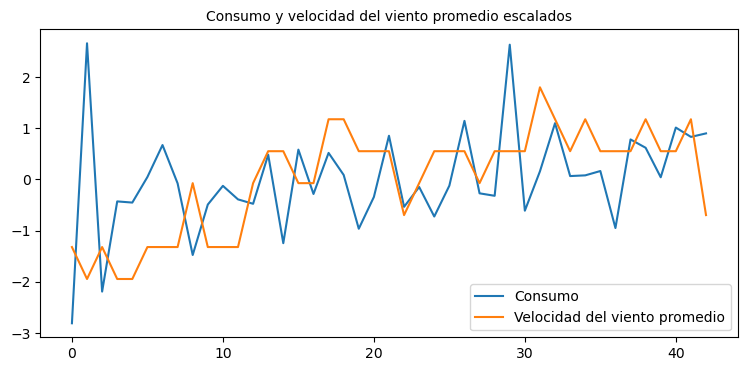

In [44]:
plt.figure(figsize=(9,4))
plt.plot(dataframe_standard_scaled['MetrosConsumidos'], label='Consumo')
plt.plot(dataframe_standard_scaled['VVPro'], label='Velocidad del viento promedio')
plt.title("Consumo y velocidad del viento promedio escalados", size = 10)
plt.legend()
plt.show()

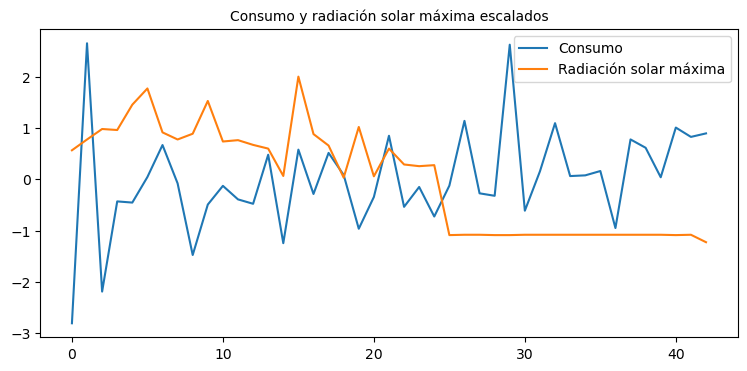

In [45]:
plt.figure(figsize=(9,4))
plt.plot(dataframe_standard_scaled['MetrosConsumidos'], label='Consumo')
plt.plot(dataframe_standard_scaled['RSMax'], label='Radiación solar máxima')
plt.title("Consumo y radiación solar máxima escalados", size = 10)
plt.legend()
plt.show()

## <span style="color:cornflowerblue">5. Predicción mensual del consumo de agua potable usando una red neuronal LSTM</span>

En Python una red neuronal LSTM se puede crear usando la librería [TensorFlow](https://www.tensorflow.org/) por medio de:

1. [tf.keras.layers.Input()](https://www.tensorflow.org/api_docs/python/tf/keras/Input): se usa para instanciar un tensor de Keras el cual se aumenta con ciertos atributos que permiten construir un modelo, solo conociendo las entradas y las salidas del modelo. El argumento 'shape' de esta función es una tupla de valores enteros.
2. [tf.keras.layers.Dropout()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout): se usa para aplicar una salida a la respectiva entrada. La capa 'Dropout' establece aleatoriamente valores iguales a cero a las unidades de entrada con una frecuencia que es igual al argumento 'rate' en cada paso durante el proceso de entrenamiento, lo cual ayuda a evitar el sobre ajuste (overfitting). El argumento 'rate' de esta función es un valor flotante entre 0 y 1, y es la fracción de las unidades de entrada a 'abandonar'.
3. [tf.keras.layers.LSTM()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Es la capa de LSTM como tal. El argumento 'units' es un entero positivo que indica la dimensionalidad del espacio de salida.
4. [tf.keras.layers.Dense()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Es la capa densamente conectada de la red neuronal.

### <span style="color:cornflowerblue"><span style="color:cornflowerblue">5.1 Preparación de los datos para el entrenamiento</span>

#### Extracción de las series que se van a utilizar para predecir el consumo

In [46]:
dataset_consumo = pd.DataFrame(dataframe['MetrosConsumidos'], index=dataframe.index)
dataset_lecturaactual = pd.DataFrame(dataframe['LecturaActual'], index=dataframe.index)
dataset_tmax = pd.DataFrame(dataframe['TMax'], index=dataframe.index)
dataset_pbmax = pd.DataFrame(dataframe['PBMax'], index=dataframe.index)
dataset_vvpro = pd.DataFrame(dataframe['VVPro'], index=dataframe.index)
dataset_rsmax = pd.DataFrame(dataframe['RSMax'], index=dataframe.index)

Revisar el tipo de las series:

In [47]:
print('dataset_consumo type is: ', type(dataset_consumo))
print('dataset_lecturaactual type is: ', type(dataset_lecturaactual))
print('dataset_tmax type is: ', type(dataset_tmax))
print('dataset_pbmax type is: ', type(dataset_pbmax))
print('dataset_vvpro type is: ', type(dataset_vvpro))
print('dataset_rsmax type is: ', type(dataset_rsmax))

dataset_consumo type is:  <class 'pandas.core.frame.DataFrame'>
dataset_lecturaactual type is:  <class 'pandas.core.frame.DataFrame'>
dataset_tmax type is:  <class 'pandas.core.frame.DataFrame'>
dataset_pbmax type is:  <class 'pandas.core.frame.DataFrame'>
dataset_vvpro type is:  <class 'pandas.core.frame.DataFrame'>
dataset_rsmax type is:  <class 'pandas.core.frame.DataFrame'>


Revisar la forma de las series:

In [48]:
print('dataset_consumo shape is: ', dataset_consumo.shape)
print('dataset_lecturaactual shape is: ', dataset_lecturaactual.shape)
print('dataset_tmax shape is: ', dataset_tmax.shape)
print('dataset_pbmax shape is: ', dataset_pbmax.shape)
print('dataset_vvpro shape is: ', dataset_vvpro.shape)
print('dataset_rsmax shape is: ', dataset_rsmax.shape)
print('dataframe shape is: ', dataframe.shape)

dataset_consumo shape is:  (43, 1)
dataset_lecturaactual shape is:  (43, 1)
dataset_tmax shape is:  (43, 1)
dataset_pbmax shape is:  (43, 1)
dataset_vvpro shape is:  (43, 1)
dataset_rsmax shape is:  (43, 1)
dataframe shape is:  (43, 6)


#### Extracción de los valores de cada una de las series

In [49]:
dataset_consumo_values = dataset_consumo.values
dataset_lecturaactual_values = dataset_lecturaactual.values
dataset_tmax_values = dataset_tmax.values
dataset_pbmax_values = dataset_pbmax.values
dataset_vvpro_values = dataset_vvpro.values
dataset_rsmax_values = dataset_rsmax.values
dataset_values = dataframe.values

Revisar el tipo de los valores de las series:

In [50]:
print('dataset_consumo_values type is: ', type(dataset_consumo_values))
print('dataset_lecturaactual_values type is: ', type(dataset_lecturaactual_values))
print('dataset_tmax_values type is: ', type(dataset_tmax_values))
print('dataset_pbmax_values type is: ', type(dataset_pbmax_values))
print('dataset_vvpro_values type is: ', type(dataset_vvpro_values))
print('dataset_rsmax_values type is: ', type(dataset_rsmax_values))
print('dataset_values type is: ', type(dataset_values))

dataset_consumo_values type is:  <class 'numpy.ndarray'>
dataset_lecturaactual_values type is:  <class 'numpy.ndarray'>
dataset_tmax_values type is:  <class 'numpy.ndarray'>
dataset_pbmax_values type is:  <class 'numpy.ndarray'>
dataset_vvpro_values type is:  <class 'numpy.ndarray'>
dataset_rsmax_values type is:  <class 'numpy.ndarray'>
dataset_values type is:  <class 'numpy.ndarray'>


Revisar la forma de los valores de las series.

In [51]:
print('dataset_consumo_values shape is: ', dataset_consumo_values.shape)
print('dataset_lecturaactual_values shape is: ', dataset_lecturaactual_values.shape)
print('dataset_tmax shape_values is: ', dataset_tmax_values.shape)
print('dataset_pbmax_values shape is: ', dataset_pbmax_values.shape)
print('dataset_vvpro_values shape is: ', dataset_vvpro_values.shape)
print('dataset_rsmax_values shape is: ', dataset_rsmax_values.shape)
print('dataset_values shape is: ', dataset_values.shape)

dataset_consumo_values shape is:  (43, 1)
dataset_lecturaactual_values shape is:  (43, 1)
dataset_tmax shape_values is:  (43, 1)
dataset_pbmax_values shape is:  (43, 1)
dataset_vvpro_values shape is:  (43, 1)
dataset_rsmax_values shape is:  (43, 1)
dataset_values shape is:  (43, 6)


#### Escalar los valores de las series

Crear el objeto 'scaler':

In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))

Escalar las series:

In [53]:
scaled_consumo = np.squeeze(np.array(scaler.fit_transform(dataset_consumo_values)), axis=1)
scaled_lecturaactual = np.squeeze(np.array(scaler.fit_transform(dataset_lecturaactual_values)), axis=1)
scaled_tmax = np.squeeze(np.array(scaler.fit_transform(dataset_tmax_values)), axis=1)
scaled_pbmax = np.squeeze(np.array(scaler.fit_transform(dataset_pbmax_values)), axis=1)
scaled_vvpro = np.squeeze(np.array(scaler.fit_transform(dataset_vvpro_values)), axis=1)
scaled_rsmax = np.squeeze(np.array(scaler.fit_transform(dataset_rsmax_values)), axis=1)
scaled_dataset = np.squeeze(np.array(scaler.fit_transform(dataset_values)))

Revisar el tipo de las series escaladas:

In [54]:
print('scaled_consumo type is: ', type(scaled_consumo))
print('scaled_lecturaactual type is: ', type(scaled_lecturaactual))
print('scaled_tmax type is: ', type(scaled_tmax))
print('scaled_pbmax type is: ', type(scaled_pbmax))
print('scaled_vvpro type is: ', type(scaled_vvpro))
print('scaled_rsmax type is: ', type(scaled_rsmax))
print('scaled_dataset type is:', type(scaled_dataset))

scaled_consumo type is:  <class 'numpy.ndarray'>
scaled_lecturaactual type is:  <class 'numpy.ndarray'>
scaled_tmax type is:  <class 'numpy.ndarray'>
scaled_pbmax type is:  <class 'numpy.ndarray'>
scaled_vvpro type is:  <class 'numpy.ndarray'>
scaled_rsmax type is:  <class 'numpy.ndarray'>
scaled_dataset type is: <class 'numpy.ndarray'>


Revisar la forma de las series escaladas:

In [55]:
print('scaled_consumo shape is: ', scaled_consumo.shape)
print('scaled_lecturaactual shape is: ', scaled_lecturaactual.shape)
print('scaled_tmax shape is: ', scaled_tmax.shape)
print('scaled_pbmax shape is: ', scaled_pbmax.shape)
print('scaled_vvpro shape is: ', scaled_vvpro.shape)
print('scaled_rsmax shape is: ', scaled_rsmax.shape)
print('scaled_dataset shape is:', scaled_dataset.shape)

scaled_consumo shape is:  (43,)
scaled_lecturaactual shape is:  (43,)
scaled_tmax shape is:  (43,)
scaled_pbmax shape is:  (43,)
scaled_vvpro shape is:  (43,)
scaled_rsmax shape is:  (43,)
scaled_dataset shape is: (43, 6)


### <span style="color:cornflowerblue"><span style="color:cornflowerblue">5.2 Función para crear los datos de entrenamiento<span/>

La siguiente función se usará en cada caso de predicción para crear los datos de entrenamiento:

In [56]:
def multipaso_data(dataset, target, start_index, end_index, history_size, target_size, single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial para tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la ventana para crear las secuencias
        target_size: número de observaciones que se desean pronosticar
        single_step: 'True' para predecir un valor futuro, 'False' para predecir todos los valores hasta target_size
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - history_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

### <span style="color:cornflowerblue">5.3 Predicción del consumo usando la serie 'Consumo'</span>

#### Creación de los datos de entrenamiento y validación

Revisar las longuitudes de la serie, de los datos de entrenamiento y de los datos de validación:

In [57]:
len_data = len(dataset_consumo)
len_train = int(len_data*0.8)
len_test = len_data - len_train
print('Longitud de la serie = Longitud de entrenamiento + Longuitud de validación\n', len_data, ' = ', len_train, ' + ', len_test)

Longitud de la serie = Longitud de entrenamiento + Longuitud de validación
 43  =  34  +  9


Como se usará el $80\%$ de los datos de la serie para entrenamiento y la longuitud de la misma es muy corta, en este caso para fines prácticos y de aplicación del modelo, se usarán un periodo de predección de 3 meses y una ventana de tiempo de 3 meses. Lo anterior para que la función de creación de los datos de entrenamiento y de validación pueda crear vectores de validación que no sean nulos.

**Nota:** Si se reduce el porcentaje de datos de entrenamiento, se podrían incrementar los periodos de predicción y de ventana de tiempo, pero debido a que la serie temporal es muy corta, dicho incremento sería pequeño.  

In [58]:
periods_to_predict = 3
window_size = 3
train_data_len = int(len_data*0.8)

X_train, y_train = multipaso_data(
    dataset=scaled_consumo, # Conjunto de datos para las secuencias de entrada
    target=scaled_consumo, # Conjunto de datos para las secuencias de salida
    start_index=0, # Índice inicial de donde empezar a tomar los datos
    end_index=train_data_len, # Índice final para tomar los datos. None para tomarlos todos
    history_size=window_size, # Tamaño de la venytana para crear las secuencias
    target_size=periods_to_predict, # Dentro de cuántas observaciones futuras desea pronosticar
    single_step=False #Predecir solamente un valor futuro (=True), predecir todos los valores hasta target_size(=False)
)

X_test, y_test = multipaso_data(
    dataset=scaled_consumo,
    target=scaled_consumo,
    start_index=train_data_len,
    end_index=None,
    history_size=window_size,
    target_size=periods_to_predict,
    single_step=False
)

Revisar el tipo de los datos de entrenamiento y validación:

In [59]:
print("X_train type is: ", type(X_train))
print("y_train is: ", type(y_train))
print("X_test is: ", type(X_test))
print("y_test is: ", type(y_test))

X_train type is:  <class 'numpy.ndarray'>
y_train is:  <class 'numpy.ndarray'>
X_test is:  <class 'numpy.ndarray'>
y_test is:  <class 'numpy.ndarray'>


Revisar la forma de los datos de entrenamiento y validación:

In [60]:
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (31, 3)
y_train shape is:  (31, 3)
X_test shape is:  (3, 3)
y_test shape is:  (3, 3)


#### Generar una semilla para garantizar reproductividad

In [61]:
tf.random.set_seed(100)

#### Crear el modelo LSTM

La forma de los datos de entrada:

In [62]:
input_shape = (X_train.shape[1], 1)
units = 50

Las capas:

In [63]:
inputs = tf.keras.layers.Input(shape=input_shape, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None,
                                       type_spec=None, # **kwargs
                              )
x = tf.keras.layers.Dropout(rate=0.1, noise_shape=None, seed=None, # **kwargs,
            name='Dropout_01')(inputs)
x = tf.keras.layers.LSTM(units=units, name='LSTM_layer')(x)
x = tf.keras.layers.Dropout(0.1, name= 'Dropout_02')(x)
outputs = tf.keras.layers.Dense(periods_to_predict)(x)

Creación del modelo:

In [64]:
model_consumo_consumo_03 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_consumo_consumo_03.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 Dropout_01 (Dropout)        (None, 3, 1)              0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


Compilación del modelo usando el optimizador Adam y la función de pérdida MSE:

In [65]:
model_consumo_consumo_03.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Entrenamiento del modelo:

In [66]:
history = model_consumo_consumo_03.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 0.2668 - val_loss: 0.3139
Epoch 2/150
1/1 [==============================] - 0s 46ms/step - loss: 0.2583 - val_loss: 0.3036
Epoch 3/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2544 - val_loss: 0.2935
Epoch 4/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2451 - val_loss: 0.2836
Epoch 5/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2384 - val_loss: 0.2739
Epoch 6/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2348 - val_loss: 0.2643
Epoch 7/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2229 - val_loss: 0.2549
Epoch 8/150
1/1 [==============================] - 0s 35ms/step - loss: 0.2151 - val_loss: 0.2457
Epoch 9/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2095 - val_loss: 0.2365
Epoch 10/150
1/1 [==============================] - 0s 33ms/step - loss: 0.1999 - val_loss: 0.2276
Epoch 11/150
1/1 [===

Visualización de los 'valores de pérdida de los datos de entrenamiento' y de los 'valores de pérdida de los datos de validación', para 'epoch' consecutivos.

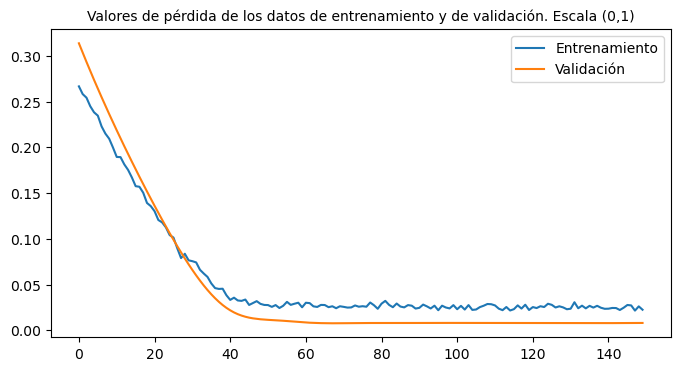

In [67]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Valores de pérdida de los datos de entrenamiento y de validación. Escala (0,1)", size = 10)
plt.legend();

In [68]:
X_test.shape

(3, 3)

#### Generación de las predicciones para las muestras de entrada:

In [69]:
prediction = model_consumo_consumo_03.predict(X_test)

1/1 [==============================] - 1s 620ms/step


Revisar las formas de los datos de validación y las predicciones:

In [70]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

(3, 3)
(3, 3)
(3, 3)


#### Visualización de las predicciones

In [71]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

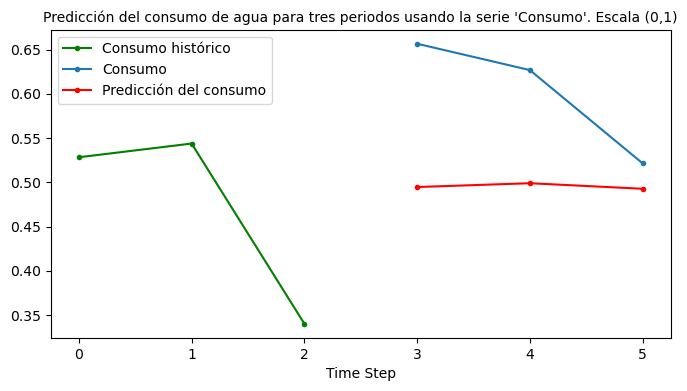

In [72]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', marker='.', label="Consumo histórico")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="Consumo")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', marker='.', label="Predicción del consumo")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Predicción del consumo de agua para tres periodos usando la serie 'Consumo'. Escala (0,1)", size = 10)
plt.legend()
plt.show();

In [73]:
model_consumo_consumo_03.save('../Data/modelo_consumo_consumo_03.h5')

### <span style="color:cornflowerblue">5.4 Predicción del consumo usando la serie 'Lectura actual'</span>

#### Creación de los datos de entrenamiento y validación

Revisar las longuitudes de la serie, de los datos de entrenamiento y de los datos de validación:

In [74]:
len_data = len(dataset_consumo)
len_train = int(len_data*0.8)
len_test = len_data - len_train
print('Longitud de la serie = Longitud de entrenamiento + Longuitud de validación\n', len_data, ' = ', len_train, ' + ', len_test)

Longitud de la serie = Longitud de entrenamiento + Longuitud de validación
 43  =  34  +  9


Como se usará el $80\%$ de los datos de la serie para entrenamiento y la longuitud de la misma es muy corta, en este caso para fines prácticos y de aplicación del modelo, se usarán un periodo de predección de 3 meses y una ventana de tiempo de 3 meses. Lo anterior para que la función de creación de los datos de entrenamiento y de validación pueda crear vectores de validación que no sean nulos.

**Nota:** Si se reduce el porcentaje de datos de entrenamiento, se podrían incrementar los periodos de predicción y de ventana de tiempo, pero debido a que la serie temporal es muy corta, dicho incremento sería pequeño.  

In [75]:
periods_to_predict = 3
window_size = 3
train_data_len = int(len_data*0.8)

X_train, y_train = multipaso_data(
    dataset=scaled_lecturaactual, # Conjunto de datos para las secuencias de entrada
    target=scaled_consumo, # Conjunto de datos para las secuencias de salida
    start_index=0, # Índice inicial de donde empezar a tomar los datos
    end_index=train_data_len, # Índice final para tomar los datos. None para tomarlos todos
    history_size=window_size, # Tamaño de la venytana para crear las secuencias
    target_size=periods_to_predict, # Dentro de cuántas observaciones futuras desea pronosticar
    single_step=False #Predecir solamente un valor futuro (=True), predecir todos los valores hasta target_size(=False)
)

X_test, y_test = multipaso_data(
    dataset=scaled_lecturaactual,
    target=scaled_consumo,
    start_index=train_data_len,
    end_index=None,
    history_size=window_size,
    target_size=periods_to_predict,
    single_step=False
)

Revisar el tipo de los datos de entrenamiento y validación:

In [76]:
print("X_train type is: ", type(X_train))
print("y_train is: ", type(y_train))
print("X_test is: ", type(X_test))
print("y_test is: ", type(y_test))

X_train type is:  <class 'numpy.ndarray'>
y_train is:  <class 'numpy.ndarray'>
X_test is:  <class 'numpy.ndarray'>
y_test is:  <class 'numpy.ndarray'>


Revisar la forma de los datos de entrenamiento y validación:

In [77]:
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (31, 3)
y_train shape is:  (31, 3)
X_test shape is:  (3, 3)
y_test shape is:  (3, 3)


#### Generar una semilla para garantizar reproductividad

In [78]:
tf.random.set_seed(100)

#### Crear el modelo LSTM

La forma de los datos de entrada:

In [79]:
input_shape = (X_train.shape[1], 1)
units = 50

Las capas:

In [80]:
inputs = tf.keras.layers.Input(shape=input_shape, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None,
                                       type_spec=None, # **kwargs
                              )
x = tf.keras.layers.Dropout(rate=0.1, noise_shape=None, seed=None, # **kwargs,
            name='Dropout_01')(inputs)
x = tf.keras.layers.LSTM(units=units, name='LSTM_layer')(x)
x = tf.keras.layers.Dropout(0.1, name= 'Dropout_02')(x)
outputs = tf.keras.layers.Dense(periods_to_predict)(x)

Creación del modelo:

In [81]:
model_consumo_lecturaactual_03 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_consumo_lecturaactual_03.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 Dropout_01 (Dropout)        (None, 3, 1)              0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


Compilación del modelo usando el optimizador Adam y la función de pérdida MSE:

In [82]:
model_consumo_lecturaactual_03.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Entrenamiento del modelo:

In [83]:
history = model_consumo_lecturaactual_03.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 0.2659 - val_loss: 0.3118
Epoch 2/150
1/1 [==============================] - 0s 35ms/step - loss: 0.2581 - val_loss: 0.2998
Epoch 3/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2543 - val_loss: 0.2880
Epoch 4/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2447 - val_loss: 0.2765
Epoch 5/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2376 - val_loss: 0.2653
Epoch 6/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2342 - val_loss: 0.2543
Epoch 7/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2230 - val_loss: 0.2435
Epoch 8/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2153 - val_loss: 0.2330
Epoch 9/150
1/1 [==============================] - 0s 31ms/step - loss: 0.2090 - val_loss: 0.2226
Epoch 10/150
1/1 [==============================] - 0s 64ms/step - loss: 0.1980 - val_loss: 0.2125
Epoch 11/150
1/1 [===

Visualización de los 'valores de pérdida de los datos de entrenamiento' y de los 'valores de pérdida de los datos de validación', para 'epoch' consecutivos.

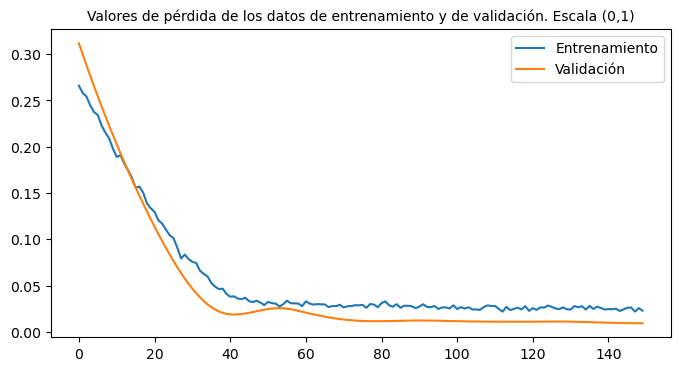

In [84]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Valores de pérdida de los datos de entrenamiento y de validación. Escala (0,1)", size = 10)
plt.legend();

In [85]:
X_test.shape

(3, 3)

#### Generación de las predicciones para las muestras de entrada:

In [86]:
prediction = model_consumo_lecturaactual_03.predict(X_test)

1/1 [==============================] - 1s 766ms/step


Revisar las formas de los datos de validación y las predicciones:

In [87]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

(3, 3)
(3, 3)
(3, 3)


#### Visualización de las predicciones

In [88]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

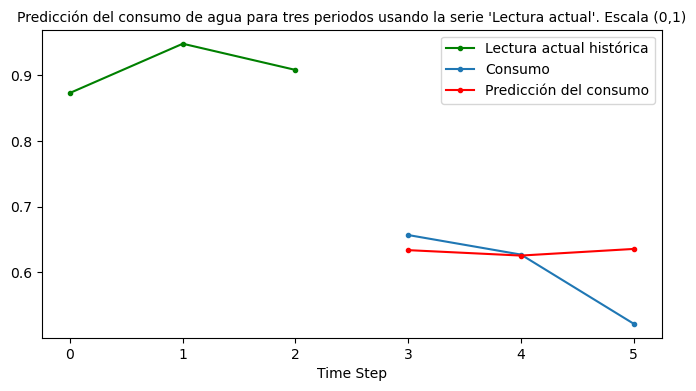

In [89]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', marker='.', label="Lectura actual histórica")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="Consumo")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', marker='.', label="Predicción del consumo")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Predicción del consumo de agua para tres periodos usando la serie 'Lectura actual'. Escala (0,1)", size = 10)
plt.legend()
plt.show();

In [90]:
model_consumo_lecturaactual_03.save('../Data/modelo_consumo_lecturaactual_03.h5')

### <span style="color:cornflowerblue">5.5 Predicción del consumo usando la serie 'Temperatura máxima'</span>

#### Creación de los datos de entrenamiento y validación

Revisar las longuitudes de la serie, de los datos de entrenamiento y de los datos de validación:

In [91]:
len_data = len(dataset_consumo)
len_train = int(len_data*0.8)
len_test = len_data - len_train
print('Longitud de la serie = Longitud de entrenamiento + Longuitud de validación\n', len_data, ' = ', len_train, ' + ', len_test)

Longitud de la serie = Longitud de entrenamiento + Longuitud de validación
 43  =  34  +  9


Como se usará el $80\%$ de los datos de la serie para entrenamiento y la longuitud de la misma es muy corta, en este caso para fines prácticos y de aplicación del modelo, se usarán un periodo de predección de 3 meses y una ventana de tiempo de 3 meses. Lo anterior para que la función de creación de los datos de entrenamiento y de validación pueda crear vectores de validación que no sean nulos.

**Nota:** Si se reduce el porcentaje de datos de entrenamiento, se podrían incrementar los periodos de predicción y de ventana de tiempo, pero debido a que la serie temporal es muy corta, dicho incremento sería pequeño.  

In [92]:
periods_to_predict = 3
window_size = 3
train_data_len = int(len_data*0.8)

X_train, y_train = multipaso_data(
    dataset=scaled_tmax, # Conjunto de datos para las secuencias de entrada
    target=scaled_consumo, # Conjunto de datos para las secuencias de salida
    start_index=0, # Índice inicial de donde empezar a tomar los datos
    end_index=train_data_len, # Índice final para tomar los datos. None para tomarlos todos
    history_size=window_size, # Tamaño de la venytana para crear las secuencias
    target_size=periods_to_predict, # Dentro de cuántas observaciones futuras desea pronosticar
    single_step=False #Predecir solamente un valor futuro (=True), predecir todos los valores hasta target_size(=False)
)

X_test, y_test = multipaso_data(
    dataset=scaled_tmax,
    target=scaled_consumo,
    start_index=train_data_len,
    end_index=None,
    history_size=window_size,
    target_size=periods_to_predict,
    single_step=False
)

Revisar el tipo de los datos de entrenamiento y validación:

In [93]:
print("X_train type is: ", type(X_train))
print("y_train is: ", type(y_train))
print("X_test is: ", type(X_test))
print("y_test is: ", type(y_test))

X_train type is:  <class 'numpy.ndarray'>
y_train is:  <class 'numpy.ndarray'>
X_test is:  <class 'numpy.ndarray'>
y_test is:  <class 'numpy.ndarray'>


Revisar la forma de los datos de entrenamiento y validación:

In [94]:
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (31, 3)
y_train shape is:  (31, 3)
X_test shape is:  (3, 3)
y_test shape is:  (3, 3)


#### Generar una semilla para garantizar reproductividad

In [95]:
tf.random.set_seed(100)

#### Crear el modelo LSTM

La forma de los datos de entrada:

In [96]:
input_shape = (X_train.shape[1], 1)
units = 50

Las capas:

In [97]:
inputs = tf.keras.layers.Input(shape=input_shape, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None,
                                       type_spec=None, # **kwargs
                              )
x = tf.keras.layers.Dropout(rate=0.1, noise_shape=None, seed=None, # **kwargs,
            name='Dropout_01')(inputs)
x = tf.keras.layers.LSTM(units=units, name='LSTM_layer')(x)
x = tf.keras.layers.Dropout(0.1, name= 'Dropout_02')(x)
outputs = tf.keras.layers.Dense(periods_to_predict)(x)

Creación del modelo:

In [98]:
model_consumo_tmax_03 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_consumo_tmax_03.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 Dropout_01 (Dropout)        (None, 3, 1)              0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


Compilación del modelo usando el optimizador Adam y la función de pérdida MSE:

In [99]:
model_consumo_tmax_03.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Entrenamiento del modelo:

In [100]:
history = model_consumo_tmax_03.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.2677 - val_loss: 0.3169
Epoch 2/150
1/1 [==============================] - 0s 41ms/step - loss: 0.2609 - val_loss: 0.3078
Epoch 3/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2568 - val_loss: 0.2989
Epoch 4/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2492 - val_loss: 0.2901
Epoch 5/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2428 - val_loss: 0.2815
Epoch 6/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2388 - val_loss: 0.2730
Epoch 7/150
1/1 [==============================] - 0s 31ms/step - loss: 0.2301 - val_loss: 0.2646
Epoch 8/150
1/1 [==============================] - 0s 35ms/step - loss: 0.2230 - val_loss: 0.2564
Epoch 9/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2191 - val_loss: 0.2482
Epoch 10/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2096 - val_loss: 0.2402
Epoch 11/150
1/1 [===

Visualización de los 'valores de pérdida de los datos de entrenamiento' y de los 'valores de pérdida de los datos de validación', para 'epoch' consecutivos.

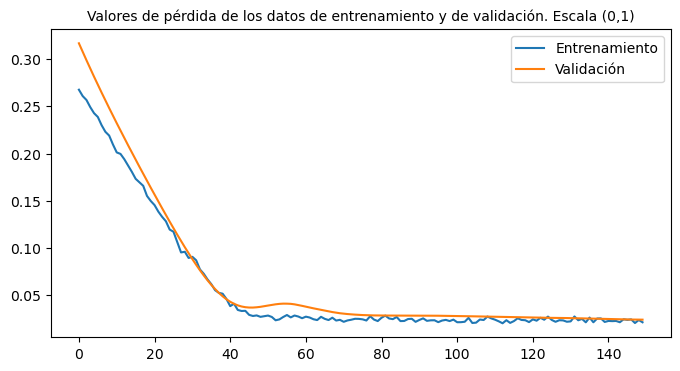

In [101]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Valores de pérdida de los datos de entrenamiento y de validación. Escala (0,1)", size = 10)
plt.legend();

In [102]:
X_test.shape

(3, 3)

#### Generación de las predicciones para las muestras de entrada:

In [103]:
prediction = model_consumo_tmax_03.predict(X_test)

1/1 [==============================] - 1s 954ms/step


Revisar las formas de los datos de validación y las predicciones:

In [104]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

(3, 3)
(3, 3)
(3, 3)


#### Visualización de las predicciones

In [105]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

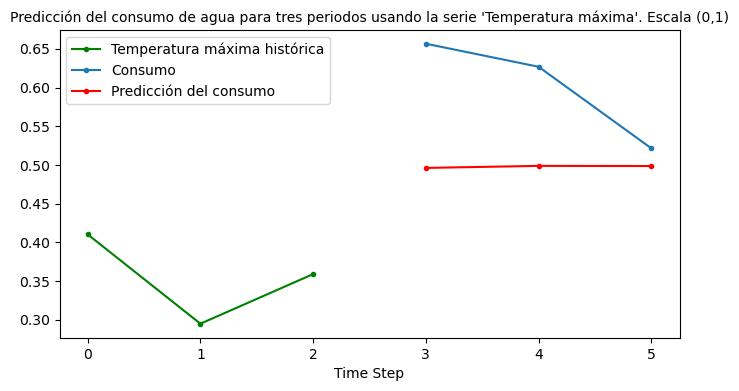

In [106]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', marker='.', label="Temperatura máxima histórica")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="Consumo")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', marker='.', label="Predicción del consumo")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Predicción del consumo de agua para tres periodos usando la serie 'Temperatura máxima'. Escala (0,1)", size = 10)
plt.legend()
plt.show();

In [107]:
model_consumo_tmax_03.save('../Data/modelo_consumo_tmax_03.h5')

### <span style="color:cornflowerblue">5.6 Predicción del consumo usando la serie 'Presión barométrica máxima'</span>

#### Creación de los datos de entrenamiento y validación

Revisar las longuitudes de la serie, de los datos de entrenamiento y de los datos de validación:

In [108]:
len_data = len(dataset_consumo)
len_train = int(len_data*0.8)
len_test = len_data - len_train
print('Longitud de la serie = Longitud de entrenamiento + Longuitud de validación\n', len_data, ' = ', len_train, ' + ', len_test)

Longitud de la serie = Longitud de entrenamiento + Longuitud de validación
 43  =  34  +  9


Como se usará el $80\%$ de los datos de la serie para entrenamiento y la longuitud de la misma es muy corta, en este caso para fines prácticos y de aplicación del modelo, se usarán un periodo de predección de 3 meses y una ventana de tiempo de 3 meses. Lo anterior para que la función de creación de los datos de entrenamiento y de validación pueda crear vectores de validación que no sean nulos.

**Nota:** Si se reduce el porcentaje de datos de entrenamiento, se podrían incrementar los periodos de predicción y de ventana de tiempo, pero debido a que la serie temporal es muy corta, dicho incremento sería pequeño.  

In [109]:
periods_to_predict = 3
window_size = 3
train_data_len = int(len_data*0.8)

X_train, y_train = multipaso_data(
    dataset=scaled_pbmax, # Conjunto de datos para las secuencias de entrada
    target=scaled_consumo, # Conjunto de datos para las secuencias de salida
    start_index=0, # Índice inicial de donde empezar a tomar los datos
    end_index=train_data_len, # Índice final para tomar los datos. None para tomarlos todos
    history_size=window_size, # Tamaño de la venytana para crear las secuencias
    target_size=periods_to_predict, # Dentro de cuántas observaciones futuras desea pronosticar
    single_step=False #Predecir solamente un valor futuro (=True), predecir todos los valores hasta target_size(=False)
)

X_test, y_test = multipaso_data(
    dataset=scaled_pbmax,
    target=scaled_consumo,
    start_index=train_data_len,
    end_index=None,
    history_size=window_size,
    target_size=periods_to_predict,
    single_step=False
)

Revisar el tipo de los datos de entrenamiento y validación:

In [110]:
print("X_train type is: ", type(X_train))
print("y_train is: ", type(y_train))
print("X_test is: ", type(X_test))
print("y_test is: ", type(y_test))

X_train type is:  <class 'numpy.ndarray'>
y_train is:  <class 'numpy.ndarray'>
X_test is:  <class 'numpy.ndarray'>
y_test is:  <class 'numpy.ndarray'>


Revisar la forma de los datos de entrenamiento y validación:

In [111]:
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (31, 3)
y_train shape is:  (31, 3)
X_test shape is:  (3, 3)
y_test shape is:  (3, 3)


#### Generar una semilla para garantizar reproductividad

In [112]:
tf.random.set_seed(100)

#### Crear el modelo LSTM

La forma de los datos de entrada:

In [113]:
input_shape = (X_train.shape[1], 1)
units = 50

Las capas:

In [114]:
inputs = tf.keras.layers.Input(shape=input_shape, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None,
                                       type_spec=None, # **kwargs
                              )
x = tf.keras.layers.Dropout(rate=0.1, noise_shape=None, seed=None, # **kwargs,
            name='Dropout_01')(inputs)
x = tf.keras.layers.LSTM(units=units, name='LSTM_layer')(x)
x = tf.keras.layers.Dropout(0.1, name= 'Dropout_02')(x)
outputs = tf.keras.layers.Dense(periods_to_predict)(x)

Creación del modelo:

In [115]:
model_consumo_pbmax_03 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_consumo_pbmax_03.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 Dropout_01 (Dropout)        (None, 3, 1)              0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


Compilación del modelo usando el optimizador Adam y la función de pérdida MSE:

In [116]:
model_consumo_pbmax_03.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Entrenamiento del modelo:

In [117]:
history = model_consumo_pbmax_03.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.2676 - val_loss: 0.3167
Epoch 2/150
1/1 [==============================] - 0s 38ms/step - loss: 0.2581 - val_loss: 0.3076
Epoch 3/150
1/1 [==============================] - 0s 37ms/step - loss: 0.2528 - val_loss: 0.2987
Epoch 4/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2430 - val_loss: 0.2899
Epoch 5/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2369 - val_loss: 0.2812
Epoch 6/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2319 - val_loss: 0.2727
Epoch 7/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2206 - val_loss: 0.2643
Epoch 8/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2122 - val_loss: 0.2560
Epoch 9/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2058 - val_loss: 0.2478
Epoch 10/150
1/1 [==============================] - 0s 34ms/step - loss: 0.1967 - val_loss: 0.2397
Epoch 11/150
1/1 [===

Visualización de los 'valores de pérdida de los datos de entrenamiento' y de los 'valores de pérdida de los datos de validación', para 'epoch' consecutivos.

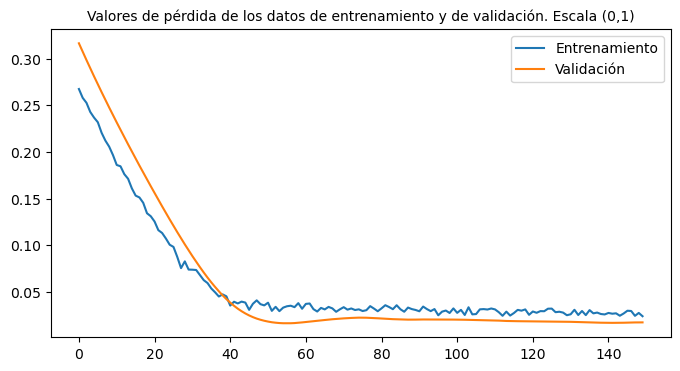

In [118]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Valores de pérdida de los datos de entrenamiento y de validación. Escala (0,1)", size = 10)
plt.legend();

In [119]:
X_test.shape

(3, 3)

#### Generación de las predicciones para las muestras de entrada:

In [120]:
prediction = model_consumo_pbmax_03.predict(X_test)

1/1 [==============================] - 1s 653ms/step


Revisar las formas de los datos de validación y las predicciones:

In [121]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

(3, 3)
(3, 3)
(3, 3)


#### Visualización de las predicciones

In [122]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

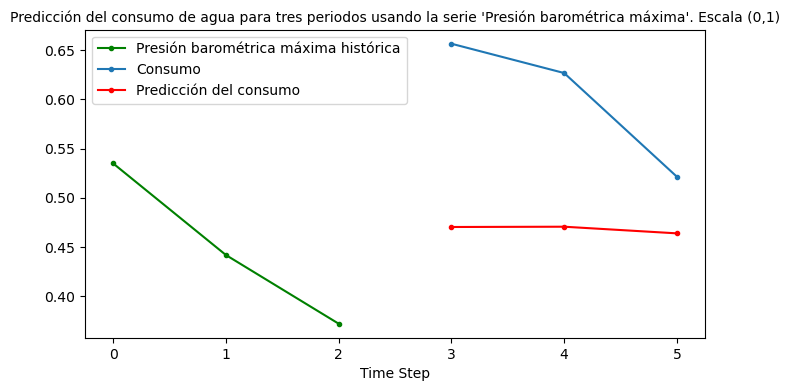

In [123]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', marker='.', label="Presión barométrica máxima histórica")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="Consumo")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', marker='.', label="Predicción del consumo")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Predicción del consumo de agua para tres periodos usando la serie 'Presión barométrica máxima'. Escala (0,1)", size = 10)
plt.legend()
plt.show();

In [124]:
model_consumo_pbmax_03.save('../Data/modelo_consumo_pbmax_03.h5')

### <span style="color:cornflowerblue">5.7 Predicción del consumo usando la serie 'Velocidad del viento promedio'</span>

#### Creación de los datos de entrenamiento y validación

Revisar las longuitudes de la serie, de los datos de entrenamiento y de los datos de validación:

In [125]:
len_data = len(dataset_consumo)
len_train = int(len_data*0.8)
len_test = len_data - len_train
print('Longitud de la serie = Longitud de entrenamiento + Longuitud de validación\n', len_data, ' = ', len_train, ' + ', len_test)

Longitud de la serie = Longitud de entrenamiento + Longuitud de validación
 43  =  34  +  9


Como se usará el $80\%$ de los datos de la serie para entrenamiento y la longuitud de la misma es muy corta, en este caso para fines prácticos y de aplicación del modelo, se usarán un periodo de predección de 3 meses y una ventana de tiempo de 3 meses. Lo anterior para que la función de creación de los datos de entrenamiento y de validación pueda crear vectores de validación que no sean nulos.

**Nota:** Si se reduce el porcentaje de datos de entrenamiento, se podrían incrementar los periodos de predicción y de ventana de tiempo, pero debido a que la serie temporal es muy corta, dicho incremento sería pequeño.  

In [126]:
periods_to_predict = 3
window_size = 3
train_data_len = int(len_data*0.8)

X_train, y_train = multipaso_data(
    dataset=scaled_vvpro, # Conjunto de datos para las secuencias de entrada
    target=scaled_consumo, # Conjunto de datos para las secuencias de salida
    start_index=0, # Índice inicial de donde empezar a tomar los datos
    end_index=train_data_len, # Índice final para tomar los datos. None para tomarlos todos
    history_size=window_size, # Tamaño de la venytana para crear las secuencias
    target_size=periods_to_predict, # Dentro de cuántas observaciones futuras desea pronosticar
    single_step=False #Predecir solamente un valor futuro (=True), predecir todos los valores hasta target_size(=False)
)

X_test, y_test = multipaso_data(
    dataset=scaled_vvpro,
    target=scaled_consumo,
    start_index=train_data_len,
    end_index=None,
    history_size=window_size,
    target_size=periods_to_predict,
    single_step=False
)

Revisar el tipo de los datos de entrenamiento y validación:

In [127]:
print("X_train type is: ", type(X_train))
print("y_train is: ", type(y_train))
print("X_test is: ", type(X_test))
print("y_test is: ", type(y_test))

X_train type is:  <class 'numpy.ndarray'>
y_train is:  <class 'numpy.ndarray'>
X_test is:  <class 'numpy.ndarray'>
y_test is:  <class 'numpy.ndarray'>


Revisar la forma de los datos de entrenamiento y validación:

In [128]:
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (31, 3)
y_train shape is:  (31, 3)
X_test shape is:  (3, 3)
y_test shape is:  (3, 3)


#### Generar una semilla para garantizar reproductividad

In [129]:
tf.random.set_seed(100)

#### Crear el modelo LSTM

La forma de los datos de entrada:

In [130]:
input_shape = (X_train.shape[1], 1)
units = 50

Las capas:

In [131]:
inputs = tf.keras.layers.Input(shape=input_shape, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None,
                                       type_spec=None, # **kwargs
                              )
x = tf.keras.layers.Dropout(rate=0.1, noise_shape=None, seed=None, # **kwargs,
            name='Dropout_01')(inputs)
x = tf.keras.layers.LSTM(units=units, name='LSTM_layer')(x)
x = tf.keras.layers.Dropout(0.1, name= 'Dropout_02')(x)
outputs = tf.keras.layers.Dense(periods_to_predict)(x)

Creación del modelo:

In [132]:
model_consumo_vvpro_03 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_consumo_vvpro_03.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 Dropout_01 (Dropout)        (None, 3, 1)              0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


Compilación del modelo usando el optimizador Adam y la función de pérdida MSE:

In [133]:
model_consumo_vvpro_03.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Entrenamiento del modelo:

In [134]:
history = model_consumo_vvpro_03.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 0.2653 - val_loss: 0.3127
Epoch 2/150
1/1 [==============================] - 0s 39ms/step - loss: 0.2583 - val_loss: 0.3014
Epoch 3/150
1/1 [==============================] - 0s 43ms/step - loss: 0.2554 - val_loss: 0.2904
Epoch 4/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2463 - val_loss: 0.2795
Epoch 5/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2388 - val_loss: 0.2689
Epoch 6/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2369 - val_loss: 0.2585
Epoch 7/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2252 - val_loss: 0.2483
Epoch 8/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2180 - val_loss: 0.2384
Epoch 9/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2123 - val_loss: 0.2286
Epoch 10/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2008 - val_loss: 0.2190
Epoch 11/150
1/1 [===

Visualización de los 'valores de pérdida de los datos de entrenamiento' y de los 'valores de pérdida de los datos de validación', para 'epoch' consecutivos.

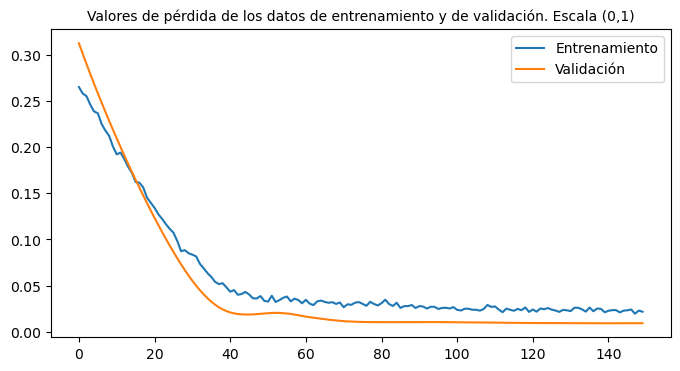

In [135]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Valores de pérdida de los datos de entrenamiento y de validación. Escala (0,1)", size = 10)
plt.legend();

In [136]:
X_test.shape

(3, 3)

#### Generación de las predicciones para las muestras de entrada:

In [137]:
prediction = model_consumo_vvpro_03.predict(X_test)

1/1 [==============================] - 1s 559ms/step


Revisar las formas de los datos de validación y las predicciones:

In [138]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

(3, 3)
(3, 3)
(3, 3)


#### Visualización de las predicciones

In [139]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

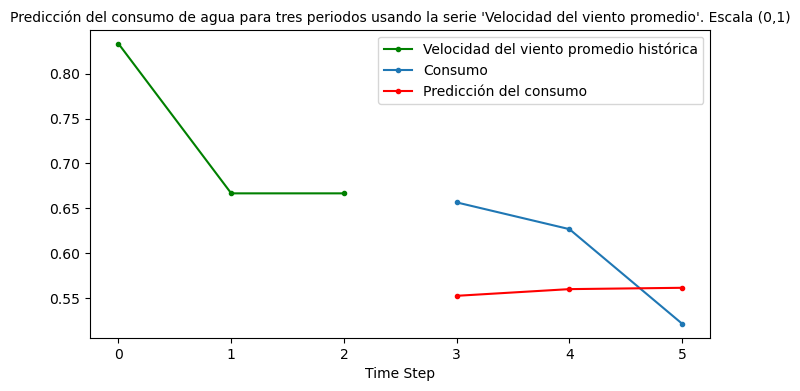

In [140]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', marker='.', label="Velocidad del viento promedio histórica")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="Consumo")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', marker='.', label="Predicción del consumo")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Predicción del consumo de agua para tres periodos usando la serie 'Velocidad del viento promedio'. Escala (0,1)", size = 10)
plt.legend()
plt.show();

In [141]:
model_consumo_vvpro_03.save('../Data/modelo_consumo_vvpro_03.h5')

### <span style="color:cornflowerblue">5.8 Predicción del consumo usando la serie 'Radiación solar máxima'</span>

#### Creación de los datos de entrenamiento y validación

Revisar las longuitudes de la serie, de los datos de entrenamiento y de los datos de validación:

In [142]:
len_data = len(dataset_consumo)
len_train = int(len_data*0.8)
len_test = len_data - len_train
print('Longitud de la serie = Longitud de entrenamiento + Longuitud de validación\n', len_data, ' = ', len_train, ' + ', len_test)

Longitud de la serie = Longitud de entrenamiento + Longuitud de validación
 43  =  34  +  9


Como se usará el $80\%$ de los datos de la serie para entrenamiento y la longuitud de la misma es muy corta, en este caso para fines prácticos y de aplicación del modelo, se usarán un periodo de predección de 3 meses y una ventana de tiempo de 3 meses. Lo anterior para que la función de creación de los datos de entrenamiento y de validación pueda crear vectores de validación que no sean nulos.

**Nota:** Si se reduce el porcentaje de datos de entrenamiento, se podrían incrementar los periodos de predicción y de ventana de tiempo, pero debido a que la serie temporal es muy corta, dicho incremento sería pequeño.  

In [143]:
periods_to_predict = 3
window_size = 3
train_data_len = int(len_data*0.8)

X_train, y_train = multipaso_data(
    dataset=scaled_rsmax, # Conjunto de datos para las secuencias de entrada
    target=scaled_consumo, # Conjunto de datos para las secuencias de salida
    start_index=0, # Índice inicial de donde empezar a tomar los datos
    end_index=train_data_len, # Índice final para tomar los datos. None para tomarlos todos
    history_size=window_size, # Tamaño de la venytana para crear las secuencias
    target_size=periods_to_predict, # Dentro de cuántas observaciones futuras desea pronosticar
    single_step=False #Predecir solamente un valor futuro (=True), predecir todos los valores hasta target_size(=False)
)

X_test, y_test = multipaso_data(
    dataset=scaled_rsmax,
    target=scaled_consumo,
    start_index=train_data_len,
    end_index=None,
    history_size=window_size,
    target_size=periods_to_predict,
    single_step=False
)

Revisar el tipo de los datos de entrenamiento y validación:

In [144]:
print("X_train type is: ", type(X_train))
print("y_train is: ", type(y_train))
print("X_test is: ", type(X_test))
print("y_test is: ", type(y_test))

X_train type is:  <class 'numpy.ndarray'>
y_train is:  <class 'numpy.ndarray'>
X_test is:  <class 'numpy.ndarray'>
y_test is:  <class 'numpy.ndarray'>


Revisar la forma de los datos de entrenamiento y validación:

In [145]:
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (31, 3)
y_train shape is:  (31, 3)
X_test shape is:  (3, 3)
y_test shape is:  (3, 3)


#### Generar una semilla para garantizar reproductividad

In [146]:
tf.random.set_seed(100)

#### Crear el modelo LSTM

La forma de los datos de entrada:

In [147]:
input_shape = (X_train.shape[1], 1)
units = 50

Las capas:

In [148]:
inputs = tf.keras.layers.Input(shape=input_shape, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None,
                                       type_spec=None, # **kwargs
                              )
x = tf.keras.layers.Dropout(rate=0.1, noise_shape=None, seed=None, # **kwargs,
            name='Dropout_01')(inputs)
x = tf.keras.layers.LSTM(units=units, name='LSTM_layer')(x)
x = tf.keras.layers.Dropout(0.1, name= 'Dropout_02')(x)
outputs = tf.keras.layers.Dense(periods_to_predict)(x)

Creación del modelo:

In [149]:
model_consumo_rsmax_03 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_consumo_rsmax_03.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 Dropout_01 (Dropout)        (None, 3, 1)              0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________


Compilación del modelo usando el optimizador Adam y la función de pérdida MSE:

In [150]:
model_consumo_rsmax_03.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Entrenamiento del modelo:

In [151]:
history = model_consumo_rsmax_03.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 0.2677 - val_loss: 0.3252
Epoch 2/150
1/1 [==============================] - 0s 36ms/step - loss: 0.2597 - val_loss: 0.3205
Epoch 3/150
1/1 [==============================] - 0s 31ms/step - loss: 0.2524 - val_loss: 0.3157
Epoch 4/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2431 - val_loss: 0.3111
Epoch 5/150
1/1 [==============================] - 0s 35ms/step - loss: 0.2379 - val_loss: 0.3064
Epoch 6/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2306 - val_loss: 0.3018
Epoch 7/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2227 - val_loss: 0.2972
Epoch 8/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2093 - val_loss: 0.2926
Epoch 9/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2082 - val_loss: 0.2880
Epoch 10/150
1/1 [==============================] - 0s 33ms/step - loss: 0.1974 - val_loss: 0.2834
Epoch 11/150
1/1 [===

Visualización de los 'valores de pérdida de los datos de entrenamiento' y de los 'valores de pérdida de los datos de validación', para 'epoch' consecutivos.

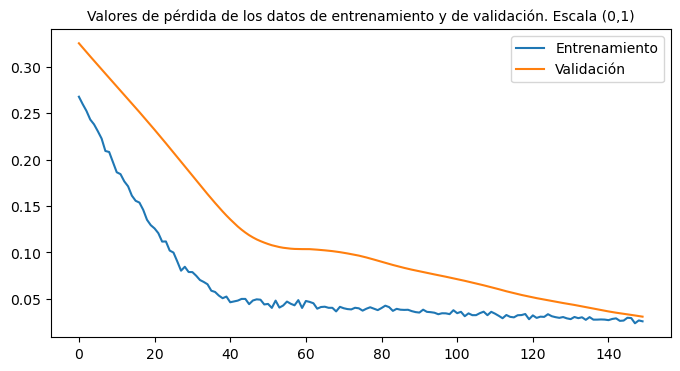

In [152]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Valores de pérdida de los datos de entrenamiento y de validación. Escala (0,1)", size = 10)
plt.legend();

In [153]:
X_test.shape

(3, 3)

#### Generación de las predicciones para las muestras de entrada:

In [154]:
prediction = model_consumo_rsmax_03.predict(X_test)

1/1 [==============================] - 1s 669ms/step


Revisar las formas de los datos de validación y las predicciones:

In [155]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

(3, 3)
(3, 3)
(3, 3)


#### Visualización de las predicciones

In [156]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

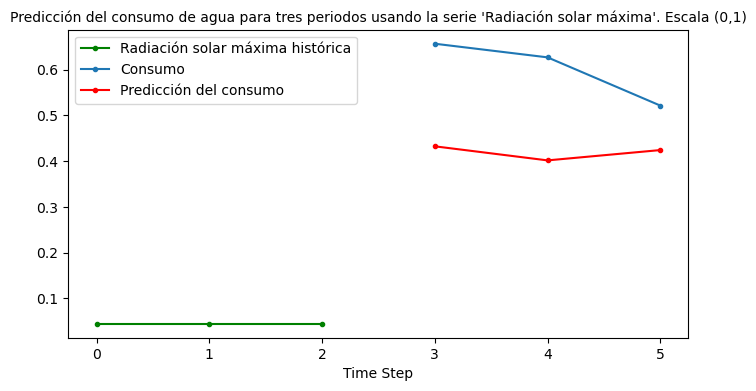

In [157]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', marker='.', label="Radiación solar máxima histórica")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="Consumo")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', marker='.', label="Predicción del consumo")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Predicción del consumo de agua para tres periodos usando la serie 'Radiación solar máxima'. Escala (0,1)", size = 10)
plt.legend()
plt.show();

In [158]:
model_consumo_rsmax_03.save('../Data/modelo_consumo_rsmax_03.h5')

### <span style="color:cornflowerblue">5.9 Predicción del consumo usando todas las series'</span>

#### Creación de los datos de entrenamiento y validación

Revisar las longuitudes de la serie, de los datos de entrenamiento y de los datos de validación:

In [159]:
len_data = len(dataset_consumo)
len_train = int(len_data*0.8)
len_test = len_data - len_train
print('Longitud de la serie = Longitud de entrenamiento + Longuitud de validación\n', len_data, ' = ', len_train, ' + ', len_test)

Longitud de la serie = Longitud de entrenamiento + Longuitud de validación
 43  =  34  +  9


Como se usará el $80\%$ de los datos de la serie para entrenamiento y la longuitud de la misma es muy corta, en este caso para fines prácticos y de aplicación del modelo, se usarán un periodo de predección de 3 meses y una ventana de tiempo de 3 meses. Lo anterior para que la función de creación de los datos de entrenamiento y de validación pueda crear vectores de validación que no sean nulos.

**Nota:** Si se reduce el porcentaje de datos de entrenamiento, se podrían incrementar los periodos de predicción y de ventana de tiempo, pero debido a que la serie temporal es muy corta, dicho incremento sería pequeño.  

In [160]:
periods_to_predict = 3
window_size = 3
train_data_len = int(len_data*0.8)

X_train, y_train = multipaso_data(
    dataset=scaled_dataset, # Conjunto de datos para las secuencias de entrada
    target=scaled_consumo, # Conjunto de datos para las secuencias de salida
    start_index=0, # Índice inicial de donde empezar a tomar los datos
    end_index=train_data_len, # Índice final para tomar los datos. None para tomarlos todos
    history_size=window_size, # Tamaño de la venytana para crear las secuencias
    target_size=periods_to_predict, # Dentro de cuántas observaciones futuras desea pronosticar
    single_step=False #Predecir solamente un valor futuro (=True), predecir todos los valores hasta target_size(=False)
)

X_test, y_test = multipaso_data(
    dataset=scaled_dataset,
    target=scaled_consumo,
    start_index=train_data_len,
    end_index=None,
    history_size=window_size,
    target_size=periods_to_predict,
    single_step=False
)

Revisar el tipo de los datos de entrenamiento y validación:

In [161]:
print("X_train type is: ", type(X_train))
print("y_train is: ", type(y_train))
print("X_test is: ", type(X_test))
print("y_test is: ", type(y_test))

X_train type is:  <class 'numpy.ndarray'>
y_train is:  <class 'numpy.ndarray'>
X_test is:  <class 'numpy.ndarray'>
y_test is:  <class 'numpy.ndarray'>


Revisar la forma de los datos de entrenamiento y validación:

In [162]:
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (31, 3, 6)
y_train shape is:  (31, 3)
X_test shape is:  (3, 3, 6)
y_test shape is:  (3, 3)


#### Generar una semilla para garantizar reproductividad

In [163]:
tf.random.set_seed(100)

#### Crear el modelo LSTM

La forma de los datos de entrada:

In [164]:
input_shape = (X_train.shape[1], 6)
units = 50

Las capas:

In [165]:
inputs = tf.keras.layers.Input(shape=input_shape, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None,
                                       type_spec=None, # **kwargs
                              )
x = tf.keras.layers.Dropout(rate=0.1, noise_shape=None, seed=None, # **kwargs,
            name='Dropout_01')(inputs)
x = tf.keras.layers.LSTM(units=units, name='LSTM_layer')(x)
x = tf.keras.layers.Dropout(0.1, name= 'Dropout_02')(x)
outputs = tf.keras.layers.Dense(periods_to_predict)(x)

Creación del modelo:

In [166]:
model_consumo_series_03 = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_consumo_series_03.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 6)]            0         
                                                                 
 Dropout_01 (Dropout)        (None, 3, 6)              0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                11400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 153       
                                                                 
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


Compilación del modelo usando el optimizador Adam y la función de pérdida MSE:

In [167]:
model_consumo_series_03.compile(loss='mean_squared_error', optimizer=Adam(0.001))

Entrenamiento del modelo:

In [168]:
history = model_consumo_series_03.fit(X_train, y_train, batch_size=32, epochs=150, verbose=1, validation_split=0.1, shuffle=False)

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 0.2977 - val_loss: 0.3417
Epoch 2/150
1/1 [==============================] - 0s 53ms/step - loss: 0.2792 - val_loss: 0.3185
Epoch 3/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2596 - val_loss: 0.2962
Epoch 4/150
1/1 [==============================] - 0s 34ms/step - loss: 0.2367 - val_loss: 0.2748
Epoch 5/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2270 - val_loss: 0.2543
Epoch 6/150
1/1 [==============================] - 0s 32ms/step - loss: 0.2183 - val_loss: 0.2346
Epoch 7/150
1/1 [==============================] - 0s 34ms/step - loss: 0.1928 - val_loss: 0.2157
Epoch 8/150
1/1 [==============================] - 0s 33ms/step - loss: 0.1749 - val_loss: 0.1977
Epoch 9/150
1/1 [==============================] - 0s 34ms/step - loss: 0.1619 - val_loss: 0.1803
Epoch 10/150
1/1 [==============================] - 0s 34ms/step - loss: 0.1448 - val_loss: 0.1638
Epoch 11/150
1/1 [===

Visualización de los 'valores de pérdida de los datos de entrenamiento' y de los 'valores de pérdida de los datos de validación', para 'epoch' consecutivos.

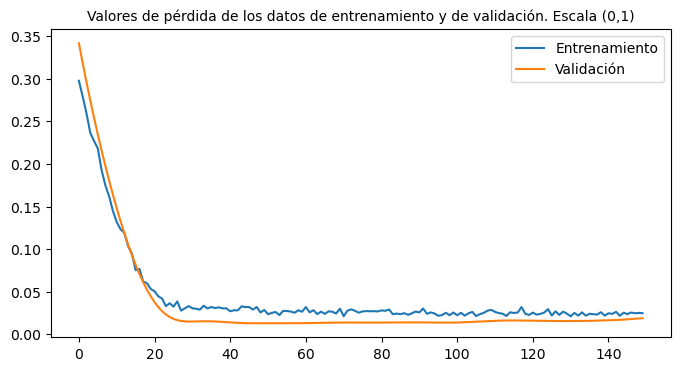

In [169]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Valores de pérdida de los datos de entrenamiento y de validación. Escala (0,1)", size = 10)
plt.legend();

In [170]:
X_test.shape

(3, 3, 6)

#### Generación de las predicciones para las muestras de entrada:

In [171]:
prediction = model_consumo_series_03.predict(X_test)

1/1 [==============================] - 1s 547ms/step


Revisar las formas de los datos de validación y las predicciones:

In [172]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

(3, 3, 6)
(3, 3)
(3, 3)


#### Visualización de las predicciones

In [173]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

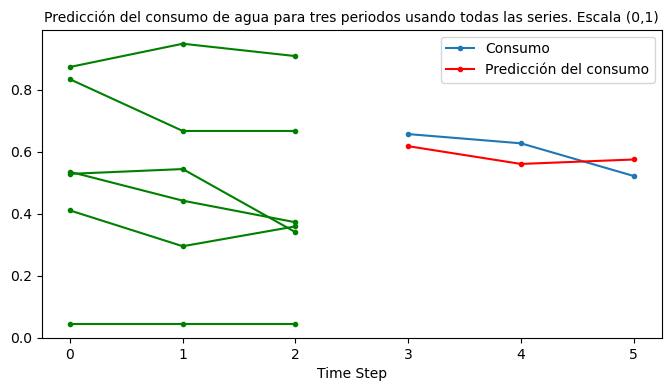

In [174]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', marker='.') #, label="Radiación solar máxima histórica")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="Consumo")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', marker='.', label="Predicción del consumo")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Predicción del consumo de agua para tres periodos usando todas las series. Escala (0,1)", size = 10)
plt.legend()
plt.show();

In [175]:
model_consumo_series_03.save('../Data/modelo_consumo_series_03.h5')